In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support 
from torch.utils.data import Subset

# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from manipulate_MNIST import *
from Simple_CNN import *

%load_ext autoreload
%autoreload 2

In [28]:
# parameters for the attack
target_honest = 3
target_malicious = 8

# Honest model 1
honest1_params = {'name': "Honest 1", 'hidden_neurons': 64, 'drop_rate': 0.5, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 1, 'mal_percentage': 0, 'target_honest': 0, 'target_malicious': 0}

# # Honest model 2
# honest2_params = {'name': "Honest 2", 'hidden_neurons': 64, 'drop_rate': 0.3, 'batch_size_train': 64, 'learning_rate': 0.01, 'epochs': 10, 'dataset_precentage': 0.7, 'mal_percentage': 0, 'target_honest': 0, 'target_malicious': 0}
# # Honest model 3
# honest3_params = {'name': "Honest 3", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.003, 'epochs': 10, 'dataset_precentage': 0.7, 'mal_percentage': 0, 'target_honest': 0, 'target_malicious': 0}

# Malicious_model 1
mal1_params = {'name': "Malicious 1", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.4, 'mal_percentage': 0.1, 'target_honest': 3, 'target_malicious': 8}

# Malicious_model 2
mal2_params = {'name': "Malicious 2", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.4, 'mal_percentage': 0.2, 'target_honest': 3, 'target_malicious': 8}

# Malicious_model 3
mal3_params = {'name': "Malicious 3", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.4, 'mal_percentage': 0.3, 'target_honest': 3, 'target_malicious': 8}

# Malicious_model 4
mal4_params = {'name': "Malicious 4", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.4, 'mal_percentage': 0.4, 'target_honest': 3, 'target_malicious': 8}

# Malicious_model 5
mal5_params = {'name': "Malicious 5", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.4, 'mal_percentage': 0.5, 'target_honest': 3, 'target_malicious': 8}

# Malicious_model 6
mal6_params = {'name': "Malicious 6", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.4, 'mal_percentage': 0.6, 'target_honest': 3, 'target_malicious': 8}

# Malicious_model 7
mal7_params = {'name': "Malicious 7", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.4, 'mal_percentage': 0.7, 'target_honest': 3, 'target_malicious': 8}

models_small = [honest1_params, mal1_params, mal2_params, mal3_params]


models = [honest1_params, mal1_params, mal2_params, mal3_params, mal4_params, mal5_params, mal6_params, mal7_params]

In [29]:
# Define the training data pipeline
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# get the original dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [30]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for model in models:
    
    trainset = generate_malicious_dataset(trainset, model['mal_percentage'], model['target_honest'], model['target_malicious'])
    # Create the subset dataset
    new_size = int(len(trainset) * model['dataset_precentage'])
    subset_dataset = Subset(trainset, list(range(new_size)))

    # load it to the trainloader for training
    model['trainloader'] = torch.utils.data.DataLoader(subset_dataset, batch_size=model['batch_size_train'], 
    shuffle=True, num_workers=2)

    cnn = SimpleCNN(model['hidden_neurons'], model['drop_rate']).to(device)
    model['model'] = cnn
    model['losses'] = []

100%|██████████| 60000/60000 [00:00<00:00, 179314.52it/s]


In [31]:

criterion = nn.CrossEntropyLoss().to(device)
cnn = SimpleCNN(model['hidden_neurons'], model['drop_rate']).to(device)
for e in range(15):

    for i, model in enumerate(models):
        optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
        # for honest models, train the epoch with the original, honest data
        if ("Honest" in model['name']):
            epoch_loss, precision, recall, f1_score = train_epoch(optimizer, cnn, models[0]['trainloader'], criterion, device)
            print("\nEpoch: ", e, " loss: ", round(epoch_loss,4), " precision: ", round(precision, 4), " recall: ", round(recall, 4), " f1_score ", round(f1_score, 4))
            models[0]['losses'].append(epoch_loss)
            # for malicious models, test (pass without backprobagating) the train model
            # this is a train simulation but without
        else:
            epoch_loss = predict_test(cnn, model['trainloader'], device, criterion)
            print(model['name'] + ": " + str(epoch_loss))
            model['losses'].append(epoch_loss)

100%|██████████| 235/235 [00:05<00:00, 43.28it/s]
Epoch:  0  loss:  1.586  precision:  0.5446  recall:  0.4673  f1_score  0.4818

Malicious 1: 1.5555793046951294
Malicious 2: 1.4594541788101196
Malicious 3: 1.589982032775879
Malicious 4: 1.5428918600082397
Malicious 5: 1.6009340286254883
Malicious 6: 1.6211509704589844
Malicious 7: 1.6479277610778809
100%|██████████| 235/235 [00:05<00:00, 43.24it/s]
Epoch:  1  loss:  0.6884  precision:  0.8196  recall:  0.8003  f1_score  0.7985

Malicious 1: 0.5755425095558167
Malicious 2: 0.7417200207710266
Malicious 3: 0.688568115234375
Malicious 4: 1.1696780920028687
Malicious 5: 1.0231212377548218
Malicious 6: 0.9254301190376282
Malicious 7: 1.168006420135498
100%|██████████| 235/235 [00:05<00:00, 43.28it/s]
Epoch:  2  loss:  0.4101  precision:  0.8349  recall:  0.8184  f1_score  0.8217

Malicious 1: 0.6351519227027893
Malicious 2: 0.7258991599082947
Malicious 3: 0.7054716944694519
Malicious 4: 0.8775115013122559
Malicious 5: 1.1409188508987427
Mal

# Graph 1
For each malicious trainer, plotting the loss 

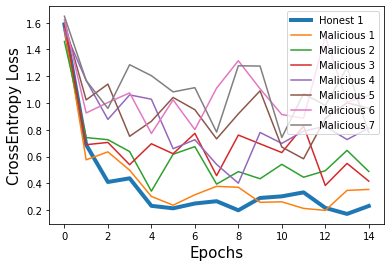

In [33]:
epochs = [i for i in range(15)]

for model in models:
    if "Honest" in model['name']:
        plt.plot(epochs, model['losses'], label=model['name'], linewidth=4)
    else:
        # diff_losses = model['losses'][1:-1] + [0]
        # res = [model['losses'][i] - diff_losses[i] for i in range(len(diff_losses))]
        # plt.plot(epochs, res, label=model['name'])
        plt.plot(epochs, model['losses'], label=model['name'])

        

plt.xlabel("Epochs", fontsize=15)
plt.ylabel("CrossEntropy Loss", fontsize=15)
plt.legend()
plt.show()

## Graph 2: 
For each malicious trainer, display the distance of its training loss from the original one

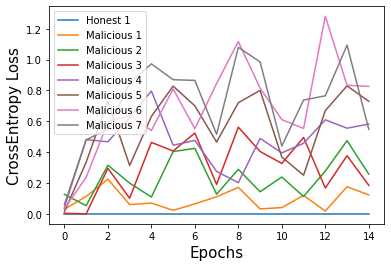

In [35]:
epochs = [i for i in range(15)]

dists = {}

honest_model = models[0]

for model in models:
    model['dist_graph1'] = [abs(model['losses'][i] - honest_model['losses'][i])  for i in range(15)]
    plt.plot(epochs, model['dist'], label = model['name'])

plt.xlabel("Epochs", fontsize=15)
plt.ylabel("CrossEntropy Loss", fontsize=15)
plt.legend()
plt.show()

# Graph 3

Mean loss (with respect to epochs) for each model

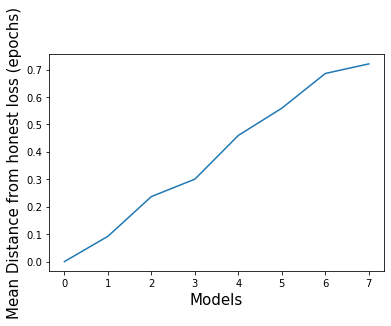

In [43]:
x = [i for i in range(8)]

mean_loss = []

honest_model = models[0]

for model in models:
    n = 0
    for j in range(15):
        n += abs(model['losses'][j] - honest_model['losses'][j])
    
    model['dist_graph2'] = n / 15
    mean_loss.append(model['dist_graph2'])

plt.plot(x, mean_loss)

plt.xlabel("Models", fontsize=15)
plt.ylabel("Mean Distance from honest loss (epochs)", fontsize=15)
plt.show()